In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [2]:
import numpy as np 

In [3]:
from tqdm import tqdm

In [4]:
import cv2

In [5]:
import os

In [6]:
import shutil

In [7]:
import itertools

In [8]:
import imutils

In [9]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.preprocessing import LabelBinarizer

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
import plotly.graph_objs as go

In [14]:
from plotly.offline import init_notebook_mode, iplot

In [15]:
from plotly import tools

In [16]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [17]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [18]:
from keras import layers

In [19]:
from keras.models import Model, Sequential

In [20]:
from keras.optimizers import Adam, RMSprop

In [21]:
from keras.callbacks import EarlyStopping

In [22]:
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [23]:
IMG_PATH = 'Dataset/'

In [24]:

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [25]:
def load_data(dir_path, img_size=(100,100)):
    
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels





In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [27]:
TRAIN_DIR = 'TRAIN/'

In [28]:
TEST_DIR = 'TEST/'

In [29]:
VAL_DIR = 'VAL/'

In [30]:
IMG_SIZE = (224,224)

In [31]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


193 images loaded from TRAIN/ directory.


In [32]:
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.31it/s]


10 images loaded from TEST/ directory.


In [33]:
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  2.00it/s]


50 images loaded from VAL/ directory.


In [34]:
y = dict()

In [35]:
y[0] = []

In [36]:
y[1] = []

In [37]:
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

In [38]:
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [39]:
def plot_samples(X, y, labels_dict, n=50):
    
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

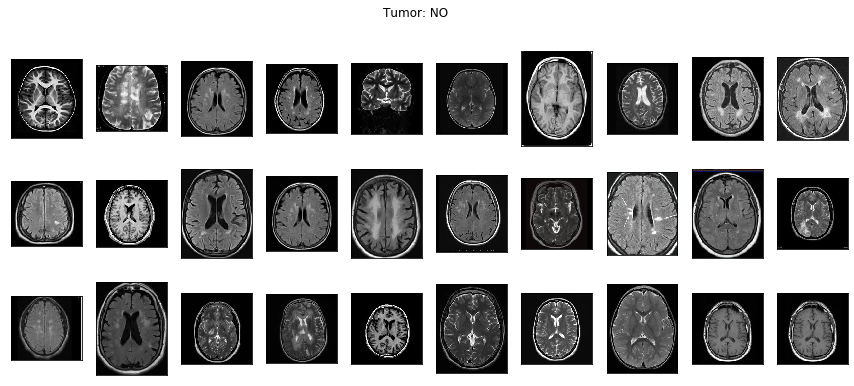

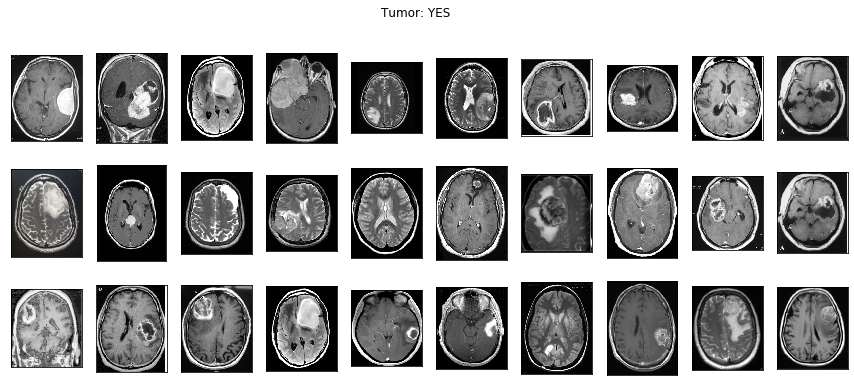

In [40]:
plot_samples(X_train, y_train, labels, 30)

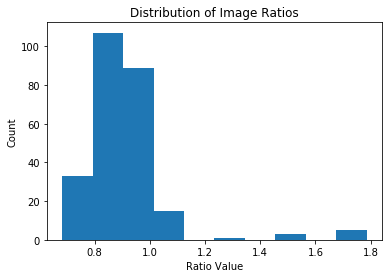

In [41]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [42]:
def crop_imgs(set_name, add_pixels_value=0):
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [43]:
img = cv2.imread('Dataset/yes/Y108.jpg')

In [44]:
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )

In [45]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [46]:
gray = cv2.GaussianBlur(gray, (5, 5), 0)

In [47]:
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

In [48]:
thresh = cv2.erode(thresh, None, iterations=2)

In [49]:
thresh = cv2.dilate(thresh, None, iterations=2)

In [50]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [51]:
cnts = imutils.grab_contours(cnts)

In [52]:
c = max(cnts, key=cv2.contourArea)

In [53]:
extLeft = tuple(c[c[:, :, 0].argmin()][0])

In [54]:
extRight = tuple(c[c[:, :, 0].argmax()][0])

In [55]:
extTop = tuple(c[c[:, :, 1].argmin()][0])

In [56]:
extBot = tuple(c[c[:, :, 1].argmax()][0])

In [57]:
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

In [58]:
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)

In [59]:
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)

In [60]:
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)

In [61]:
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

In [62]:
ADD_PIXELS = 0

In [63]:
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

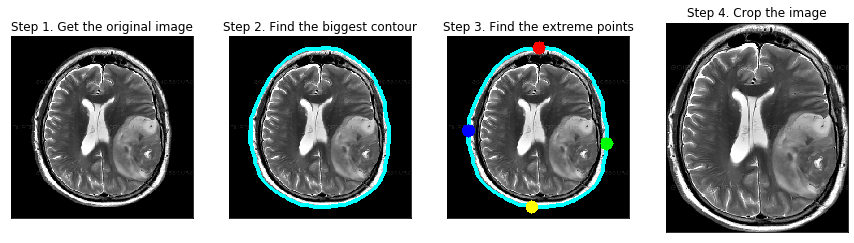

In [64]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [65]:
import cv2

def getInfo(imgs, img_path):
    print('Image Information')
    print('==================')
    print('Path:', img_path)

    try:
        for img in imgs:
            print('shape: {} size:{}'.format(img.shape, img.size))
    except TypeError:
        print('ERROR: TypeError, please check function input')


def getImage(img_path, display=True):
    img = cv2.imread(img_path)
    b, g, r = cv2.split(img)
    image_block = [img, b, g, r]

    if display:
        getInfo(image_block, img_path)

        cv2.imshow('Brain', img)
        cv2.imshow('B channel', b)
        cv2.imshow('G channel', g)
        cv2.imshow('R channel', r)

        cv2.waitKey()

    return image_block


def multiPyrDown(img, debug=False):
    result = [img]
    temp_img = img.copy()

    print('### Starting Multi-PyrDown ###')
    while temp_img.size > 4:
        if debug:
            print(temp_img.shape)
        temp_img = cv2.pyrDown(temp_img)
        result.append(temp_img)

    print('### Multi-PyrDown, Done with length: {} ###'.format(len(result)))

    return result

In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = mpimg.imread('Dataset/yes/Y1.jpg')
gray_img = rgb2gray(img)

In [67]:
pyr_img = multiPyrDown(gray_img, debug=True)

### Starting Multi-PyrDown ###
(218, 180)
(109, 90)
(55, 45)
(28, 23)
(14, 12)
(7, 6)
(4, 3)
### Multi-PyrDown, Done with length: 8 ###


In [68]:
X_train_crop = crop_imgs(set_name=X_train)

In [69]:
X_val_crop = crop_imgs(set_name=X_val)

In [70]:
X_test_crop = crop_imgs(set_name=X_test)

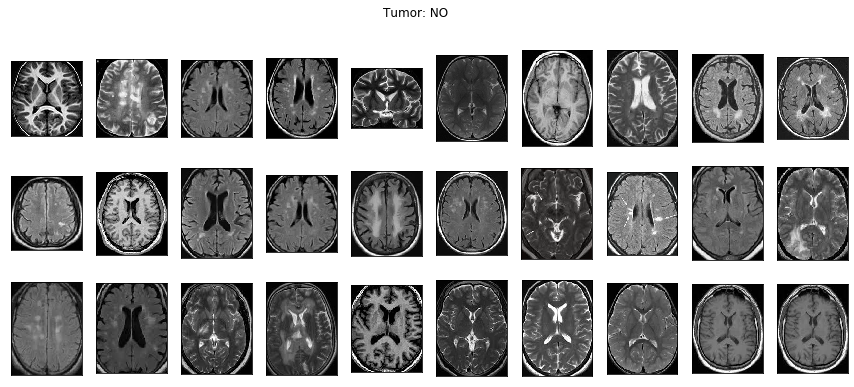

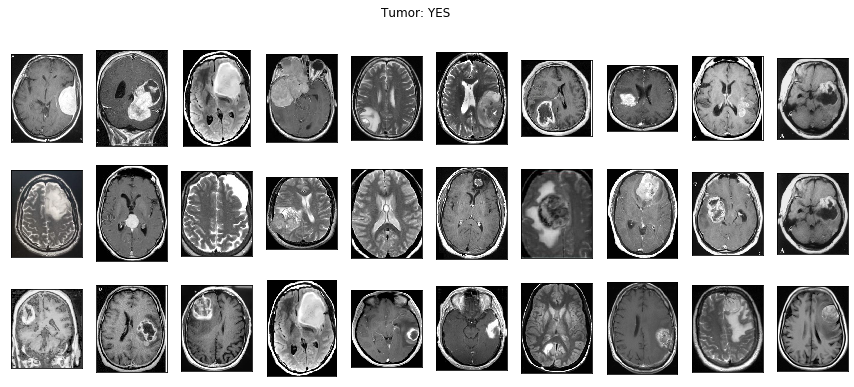

In [71]:
plot_samples(X_train_crop, y_train, labels, 30)

In [72]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [73]:


save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [74]:
def preprocess_imgs(set_name, img_size):
    
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [75]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [76]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [77]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

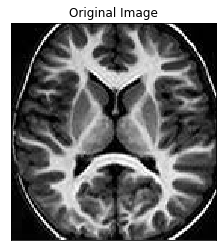

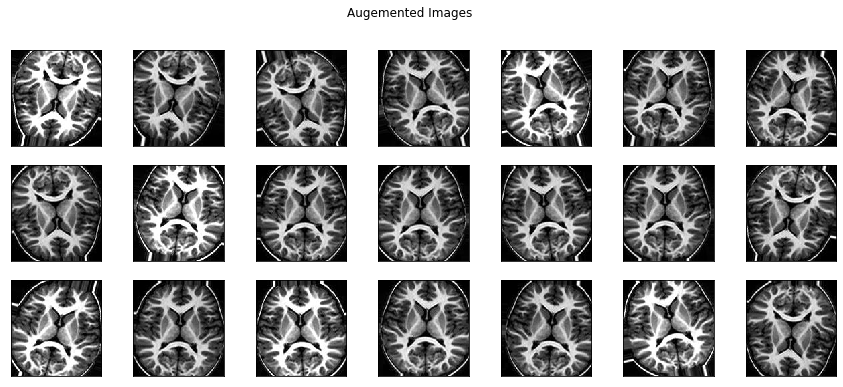

In [78]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [79]:
!rm -rf preview/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [80]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [81]:
# load base model
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [82]:
NUM_CLASSES = 1

In [83]:
model = Sequential()

In [84]:
model.add(base_model)

In [85]:
model.add(layers.Flatten())

In [86]:
model.add(layers.Dropout(0.5))

In [87]:
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

In [88]:
model.layers[0].trainable = False

In [89]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [91]:
EPOCHS = 30

In [92]:
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

In [93]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 [==============================] - ETA: 33:54 - loss: 9.9824 - accuracy: 0.375 - ETA: 33:24 - loss: 6.7737 - accuracy: 0.484 - ETA: 22:05 - loss: 15.3293 - accuracy: 0.47 - ETA: 24:37 - loss: 12.7161 - accuracy: 0.51 - ETA: 25:31 - loss: 11.2089 - accuracy: 0.54 - ETA: 25:41 - loss: 10.2037 - accuracy: 0.56 - ETA: 25:15 - loss: 9.7953 - accuracy: 0.5492 - ETA: 21:41 - loss: 8.5724 - accuracy: 0.551 - ETA: 21:20 - loss: 8.2251 - accuracy: 0.553 - ETA: 20:49 - loss: 7.8770 - accuracy: 0.562 - ETA: 20:31 - loss: 7.5069 - accuracy: 0.582 - ETA: 20:13 - loss: 7.1562 - accuracy: 0.587 - ETA: 19:20 - loss: 6.9928 - accuracy: 0.587 - ETA: 18:42 - loss: 6.9681 - accuracy: 0.582 - ETA: 17:00 - loss: 7.7341 - accuracy: 0.581 - ETA: 16:18 - loss: 7.4760 - accuracy: 0.572 - ETA: 15:39 - loss: 7.4063 - accuracy: 0.565 - ETA: 15:04 - loss: 7.1671 - accuracy: 0.565 - ETA: 14:28 - loss: 6.9564 - accuracy: 0.572 - ETA: 13:55 - loss: 6.8716 - accuracy: 0.570 - ETA: 13:24 - loss: 6.8026 -

C:\Anacondapython\data\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning:

Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy



Epoch 2/30
50/50 [==============================] - ETA: 16:14 - loss: 2.2395 - accuracy: 0.781 - ETA: 8:14 - loss: 1.1479 - accuracy: 0.787 - ETA: 10:35 - loss: 1.4876 - accuracy: 0.692 - ETA: 11:35 - loss: 1.5610 - accuracy: 0.711 - ETA: 12:05 - loss: 2.6295 - accuracy: 0.635 - ETA: 12:39 - loss: 2.4256 - accuracy: 0.670 - ETA: 12:38 - loss: 2.5136 - accuracy: 0.668 - ETA: 12:33 - loss: 2.8943 - accuracy: 0.648 - ETA: 12:24 - loss: 3.0015 - accuracy: 0.638 - ETA: 12:14 - loss: 2.9085 - accuracy: 0.636 - ETA: 10:53 - loss: 2.7079 - accuracy: 0.634 - ETA: 10:47 - loss: 2.8305 - accuracy: 0.649 - ETA: 10:47 - loss: 2.9725 - accuracy: 0.649 - ETA: 9:46 - loss: 2.7602 - accuracy: 0.650 - ETA: 9:40 - loss: 2.6711 - accuracy: 0.66 - ETA: 9:31 - loss: 2.8230 - accuracy: 0.66 - ETA: 9:22 - loss: 2.9268 - accuracy: 0.66 - ETA: 9:11 - loss: 2.9365 - accuracy: 0.67 - ETA: 8:58 - loss: 3.0816 - accuracy: 0.66 - ETA: 8:49 - loss: 3.1061 - accuracy: 0.66 - ETA: 8:35 - loss: 3.1128 - accuracy: 0.66 

50/50 [==============================] - ETA: 16:21 - loss: 3.4563 - accuracy: 0.781 - ETA: 8:18 - loss: 1.7281 - accuracy: 0.787 - ETA: 11:18 - loss: 1.9085 - accuracy: 0.800 - ETA: 12:06 - loss: 1.6363 - accuracy: 0.804 - ETA: 12:28 - loss: 1.4326 - accuracy: 0.821 - ETA: 12:35 - loss: 1.3094 - accuracy: 0.838 - ETA: 12:35 - loss: 1.4672 - accuracy: 0.829 - ETA: 12:29 - loss: 1.6115 - accuracy: 0.817 - ETA: 12:21 - loss: 1.7432 - accuracy: 0.793 - ETA: 10:54 - loss: 1.5688 - accuracy: 0.794 - ETA: 10:59 - loss: 1.7036 - accuracy: 0.796 - ETA: 10:52 - loss: 1.6512 - accuracy: 0.791 - ETA: 10:43 - loss: 1.7608 - accuracy: 0.782 - ETA: 10:33 - loss: 1.7259 - accuracy: 0.782 - ETA: 9:36 - loss: 1.6108 - accuracy: 0.782 - ETA: 9:27 - loss: 1.6381 - accuracy: 0.78 - ETA: 9:22 - loss: 1.6344 - accuracy: 0.77 - ETA: 9:11 - loss: 1.7370 - accuracy: 0.77 - ETA: 8:58 - loss: 1.7896 - accuracy: 0.77 - ETA: 8:44 - loss: 1.8078 - accuracy: 0.77 - ETA: 8:30 - loss: 1.8530 - accuracy: 0.77 - ETA: 8:

50/50 [==============================] - ETA: 19:48 - loss: 2.3207 - accuracy: 0.812 - ETA: 19:19 - loss: 1.7278 - accuracy: 0.812 - ETA: 18:52 - loss: 1.2370 - accuracy: 0.843 - ETA: 18:27 - loss: 1.3843 - accuracy: 0.843 - ETA: 18:17 - loss: 1.5526 - accuracy: 0.843 - ETA: 15:00 - loss: 1.2938 - accuracy: 0.844 - ETA: 15:18 - loss: 1.4459 - accuracy: 0.834 - ETA: 15:10 - loss: 1.5541 - accuracy: 0.835 - ETA: 14:59 - loss: 1.4627 - accuracy: 0.836 - ETA: 14:46 - loss: 1.4891 - accuracy: 0.823 - ETA: 13:08 - loss: 1.3537 - accuracy: 0.824 - ETA: 13:00 - loss: 1.2505 - accuracy: 0.838 - ETA: 12:49 - loss: 1.2238 - accuracy: 0.844 - ETA: 12:45 - loss: 1.1695 - accuracy: 0.844 - ETA: 12:31 - loss: 1.1766 - accuracy: 0.846 - ETA: 12:16 - loss: 1.2617 - accuracy: 0.840 - ETA: 11:14 - loss: 1.1875 - accuracy: 0.840 - ETA: 11:00 - loss: 1.2306 - accuracy: 0.840 - ETA: 10:44 - loss: 1.2281 - accuracy: 0.842 - ETA: 10:28 - loss: 1.3066 - accuracy: 0.835 - ETA: 10:15 - loss: 1.2737 - accuracy: 0

50/50 [==============================] - ETA: 38s - loss: 2.4773e-10 - accuracy: 1.000 - ETA: 10:03 - loss: 0.5179 - accuracy: 0.8182  - ETA: 12:33 - loss: 0.9008 - accuracy: 0.769 - ETA: 14:06 - loss: 0.8222 - accuracy: 0.824 - ETA: 11:09 - loss: 0.6912 - accuracy: 0.826 - ETA: 11:47 - loss: 0.6943 - accuracy: 0.838 - ETA: 11:57 - loss: 0.8590 - accuracy: 0.845 - ETA: 11:59 - loss: 0.7978 - accuracy: 0.855 - ETA: 11:57 - loss: 0.7496 - accuracy: 0.871 - ETA: 11:51 - loss: 0.7647 - accuracy: 0.868 - ETA: 11:51 - loss: 0.7183 - accuracy: 0.879 - ETA: 11:40 - loss: 0.7017 - accuracy: 0.885 - ETA: 11:30 - loss: 0.7329 - accuracy: 0.881 - ETA: 11:24 - loss: 0.7330 - accuracy: 0.878 - ETA: 11:15 - loss: 0.7405 - accuracy: 0.878 - ETA: 11:04 - loss: 0.7924 - accuracy: 0.877 - ETA: 10:51 - loss: 0.7719 - accuracy: 0.881 - ETA: 9:58 - loss: 0.7290 - accuracy: 0.882 - ETA: 9:51 - loss: 0.7079 - accuracy: 0.88 - ETA: 9:39 - loss: 0.6971 - accuracy: 0.88 - ETA: 9:26 - loss: 0.6987 - accuracy: 0.8

50/50 [==============================] - ETA: 23:38 - loss: 0.7532 - accuracy: 0.906 - ETA: 23:31 - loss: 0.7408 - accuracy: 0.921 - ETA: 23:14 - loss: 0.7768 - accuracy: 0.906 - ETA: 22:37 - loss: 1.2068 - accuracy: 0.882 - ETA: 22:12 - loss: 1.0792 - accuracy: 0.881 - ETA: 21:41 - loss: 0.9547 - accuracy: 0.890 - ETA: 18:14 - loss: 0.8184 - accuracy: 0.891 - ETA: 18:16 - loss: 0.7506 - accuracy: 0.902 - ETA: 15:55 - loss: 0.6672 - accuracy: 0.902 - ETA: 15:52 - loss: 0.6207 - accuracy: 0.910 - ETA: 15:51 - loss: 0.6689 - accuracy: 0.910 - ETA: 15:47 - loss: 0.6664 - accuracy: 0.903 - ETA: 15:34 - loss: 0.6704 - accuracy: 0.901 - ETA: 15:17 - loss: 0.6848 - accuracy: 0.901 - ETA: 15:00 - loss: 0.7027 - accuracy: 0.899 - ETA: 13:42 - loss: 0.6588 - accuracy: 0.899 - ETA: 13:27 - loss: 0.6529 - accuracy: 0.895 - ETA: 13:11 - loss: 0.6975 - accuracy: 0.896 - ETA: 12:53 - loss: 0.7323 - accuracy: 0.889 - ETA: 12:38 - loss: 0.7440 - accuracy: 0.888 - ETA: 12:19 - loss: 0.8133 - accuracy: 0

50/50 [==============================] - ETA: 16:09 - loss: 0.3061 - accuracy: 0.968 - ETA: 8:11 - loss: 0.1531 - accuracy: 0.969 - ETA: 10:30 - loss: 0.2155 - accuracy: 0.969 - ETA: 11:31 - loss: 0.1758 - accuracy: 0.969 - ETA: 12:23 - loss: 0.2160 - accuracy: 0.953 - ETA: 12:30 - loss: 0.1805 - accuracy: 0.962 - ETA: 12:30 - loss: 0.2301 - accuracy: 0.958 - ETA: 12:24 - loss: 0.2121 - accuracy: 0.955 - ETA: 10:49 - loss: 0.1885 - accuracy: 0.955 - ETA: 10:49 - loss: 0.2683 - accuracy: 0.953 - ETA: 10:47 - loss: 0.3013 - accuracy: 0.948 - ETA: 10:48 - loss: 0.3434 - accuracy: 0.941 - ETA: 10:39 - loss: 0.3759 - accuracy: 0.932 - ETA: 10:28 - loss: 0.4046 - accuracy: 0.930 - ETA: 10:16 - loss: 0.4368 - accuracy: 0.928 - ETA: 10:03 - loss: 0.5091 - accuracy: 0.920 - ETA: 9:49 - loss: 0.5368 - accuracy: 0.914 - ETA: 9:35 - loss: 0.5190 - accuracy: 0.91 - ETA: 8:49 - loss: 0.4916 - accuracy: 0.91 - ETA: 8:40 - loss: 0.4968 - accuracy: 0.91 - ETA: 8:26 - loss: 0.4798 - accuracy: 0.92 - ETA

50/50 [==============================] - ETA: 16:09 - loss: 0.5010 - accuracy: 0.906 - ETA: 16:54 - loss: 0.7423 - accuracy: 0.875 - ETA: 16:12 - loss: 0.6787 - accuracy: 0.906 - ETA: 15:40 - loss: 0.8117 - accuracy: 0.890 - ETA: 15:13 - loss: 0.6815 - accuracy: 0.900 - ETA: 14:50 - loss: 0.7395 - accuracy: 0.901 - ETA: 12:30 - loss: 0.6338 - accuracy: 0.901 - ETA: 12:24 - loss: 0.7008 - accuracy: 0.897 - ETA: 12:32 - loss: 0.6643 - accuracy: 0.906 - ETA: 12:20 - loss: 0.5999 - accuracy: 0.917 - ETA: 12:06 - loss: 0.5719 - accuracy: 0.915 - ETA: 11:51 - loss: 0.6041 - accuracy: 0.917 - ETA: 11:36 - loss: 0.6436 - accuracy: 0.911 - ETA: 11:20 - loss: 0.6921 - accuracy: 0.908 - ETA: 10:18 - loss: 0.8508 - accuracy: 0.906 - ETA: 10:11 - loss: 0.8712 - accuracy: 0.906 - ETA: 9:57 - loss: 0.8406 - accuracy: 0.908 - ETA: 9:41 - loss: 0.8282 - accuracy: 0.91 - ETA: 9:26 - loss: 0.8240 - accuracy: 0.90 - ETA: 9:10 - loss: 0.8184 - accuracy: 0.91 - ETA: 8:54 - loss: 0.8143 - accuracy: 0.91 - ET

50/50 [==============================] - ETA: 16:23 - loss: 0.1116 - accuracy: 0.968 - ETA: 15:58 - loss: 0.1779 - accuracy: 0.953 - ETA: 15:34 - loss: 0.2878 - accuracy: 0.958 - ETA: 15:13 - loss: 0.3166 - accuracy: 0.953 - ETA: 14:54 - loss: 0.2719 - accuracy: 0.956 - ETA: 12:15 - loss: 0.2266 - accuracy: 0.956 - ETA: 12:34 - loss: 0.2801 - accuracy: 0.948 - ETA: 12:29 - loss: 0.2609 - accuracy: 0.951 - ETA: 12:20 - loss: 0.3137 - accuracy: 0.949 - ETA: 12:08 - loss: 0.3709 - accuracy: 0.948 - ETA: 10:48 - loss: 0.3372 - accuracy: 0.948 - ETA: 10:41 - loss: 0.3475 - accuracy: 0.944 - ETA: 10:40 - loss: 0.3776 - accuracy: 0.943 - ETA: 10:29 - loss: 0.3643 - accuracy: 0.945 - ETA: 10:17 - loss: 0.3400 - accuracy: 0.949 - ETA: 10:04 - loss: 0.3569 - accuracy: 0.948 - ETA: 9:50 - loss: 0.3647 - accuracy: 0.948 - ETA: 9:02 - loss: 0.3444 - accuracy: 0.94 - ETA: 8:49 - loss: 0.3431 - accuracy: 0.94 - ETA: 8:40 - loss: 0.3805 - accuracy: 0.94 - ETA: 8:00 - loss: 0.3625 - accuracy: 0.94 - ET

50/50 [==============================] - ETA: 25:06 - loss: 0.2293 - accuracy: 0.937 - ETA: 24:53 - loss: 0.5163 - accuracy: 0.906 - ETA: 24:07 - loss: 0.5409 - accuracy: 0.916 - ETA: 23:18 - loss: 0.4832 - accuracy: 0.929 - ETA: 18:22 - loss: 0.3866 - accuracy: 0.930 - ETA: 18:37 - loss: 0.3789 - accuracy: 0.931 - ETA: 18:42 - loss: 0.5144 - accuracy: 0.922 - ETA: 18:36 - loss: 0.4615 - accuracy: 0.924 - ETA: 18:20 - loss: 0.4275 - accuracy: 0.926 - ETA: 18:02 - loss: 0.4588 - accuracy: 0.917 - ETA: 17:47 - loss: 0.4176 - accuracy: 0.925 - ETA: 17:28 - loss: 0.4093 - accuracy: 0.923 - ETA: 17:07 - loss: 0.4311 - accuracy: 0.924 - ETA: 15:30 - loss: 0.4003 - accuracy: 0.924 - ETA: 15:16 - loss: 0.3747 - accuracy: 0.930 - ETA: 14:59 - loss: 0.3723 - accuracy: 0.931 - ETA: 14:38 - loss: 0.3505 - accuracy: 0.935 - ETA: 14:17 - loss: 0.3798 - accuracy: 0.937 - ETA: 13:55 - loss: 0.3667 - accuracy: 0.937 - ETA: 13:35 - loss: 0.3616 - accuracy: 0.937 - ETA: 12:31 - loss: 0.3444 - accuracy: 0

50/50 [==============================] - ETA: 16:10 - loss: 0.2675 - accuracy: 0.906 - ETA: 15:58 - loss: 0.4246 - accuracy: 0.921 - ETA: 15:36 - loss: 0.3934 - accuracy: 0.937 - ETA: 11:35 - loss: 0.2951 - accuracy: 0.938 - ETA: 12:01 - loss: 0.2425 - accuracy: 0.945 - ETA: 12:39 - loss: 0.2790 - accuracy: 0.950 - ETA: 13:11 - loss: 0.3586 - accuracy: 0.943 - ETA: 13:02 - loss: 0.3899 - accuracy: 0.937 - ETA: 12:50 - loss: 0.3502 - accuracy: 0.941 - ETA: 12:35 - loss: 0.3282 - accuracy: 0.941 - ETA: 12:20 - loss: 0.2984 - accuracy: 0.947 - ETA: 11:03 - loss: 0.2735 - accuracy: 0.947 - ETA: 10:53 - loss: 0.2686 - accuracy: 0.946 - ETA: 10:53 - loss: 0.2676 - accuracy: 0.945 - ETA: 10:38 - loss: 0.2640 - accuracy: 0.945 - ETA: 10:24 - loss: 0.2519 - accuracy: 0.946 - ETA: 10:08 - loss: 0.2635 - accuracy: 0.946 - ETA: 9:52 - loss: 0.2824 - accuracy: 0.945 - ETA: 9:36 - loss: 0.2781 - accuracy: 0.94 - ETA: 8:51 - loss: 0.2642 - accuracy: 0.94 - ETA: 8:40 - loss: 0.2624 - accuracy: 0.94 - 

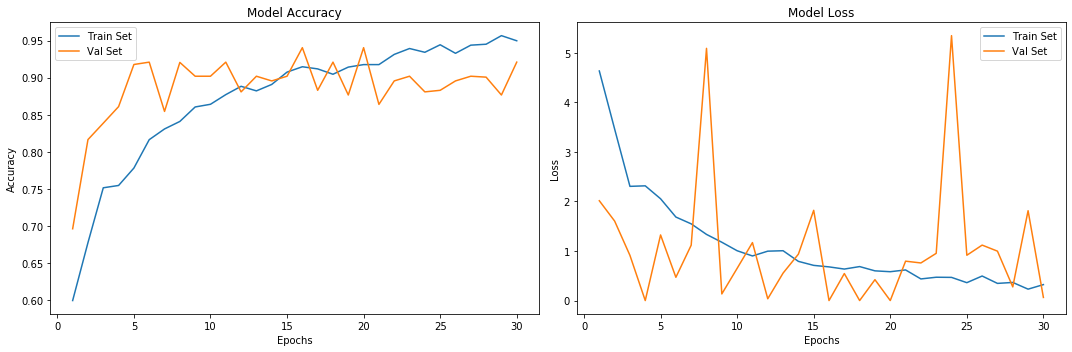

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [95]:
predictions = model.predict(X_val_prep)

In [96]:
predictions = [1 if x>0.5 else 0 for x in predictions]

In [97]:
accuracy = accuracy_score(y_val, predictions)

In [98]:
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.92


In [99]:
confusion_mtx = confusion_matrix(y_val, predictions) 

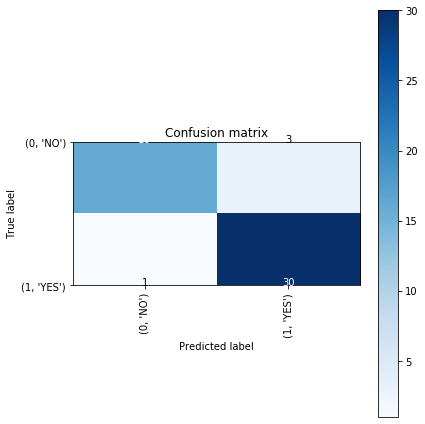

In [100]:
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [101]:
predictions = model.predict(X_test_prep)

In [102]:
predictions = [1 if x>0.5 else 0 for x in predictions]

In [103]:
accuracy = accuracy_score(y_test, predictions)

In [104]:
print('Test Accuracy = %.2f' % accuracy)

Test Accuracy = 1.00


In [105]:
confusion_mtx = confusion_matrix(y_test, predictions) 

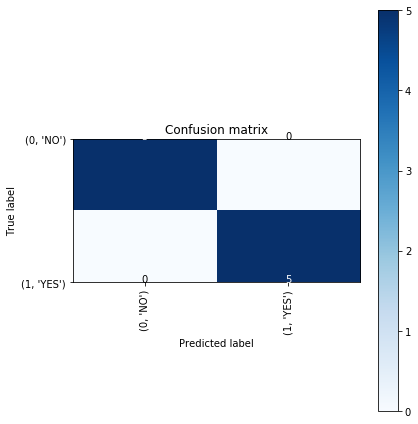

In [106]:
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [107]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

In [108]:
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

There are no missclassified images.
